In [1]:
import pandas as pd
from data_cleaning.calc_fpoints import calc_fpoints_batter, calc_fpoints_pitcher
from data_cleaning.combine_dfs import combine_metrics_stats, pitch_combine_metrics_stats
from plotting.plots import plot_top_x_corr
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [2]:
# Reading in data and calculating fantasy points
# Minimum PA of 50 for both datasets
pitcher_data = pd.read_csv("data/pitcher_stats_base.csv")
pitcher_fpoints = calc_fpoints_pitcher(pitcher_data, output = False)
pitcher_fpoints.head()


,Name,year,age,IP,H,K,BB,ER,S,W,L,Hold,Fpoints,Fpoints_IP
0,"Colon, Bartolo",2015,42,194.2,217,136,24,90,0,14,13,0,297.6,1.532441
1,"Hawkins, LaTroy",2015,42,38.2,44,34,7,14,3,3,1,7,69.6,1.821990
2,"Wolf, Randy",2015,38,34.2,46,28,15,24,0,0,5,1,21.6,0.631579
3,"Marquis, Jason",2015,36,47.1,64,37,14,34,0,3,4,0,32.3,0.685775
4,"Burnett, A.J.",2015,38,164.0,174,143,49,58,0,9,7,0,296.0,1.804878


In [3]:
fpoints2024 = pitcher_fpoints[pitcher_fpoints['year'] == 2024][["Name", "Fpoints_IP"]]

In [4]:
pitcher_metrics = pd.read_csv("data/pitcher_metrics.csv")
pitcher_combined = pitch_combine_metrics_stats(pitcher_fpoints, pitcher_metrics, save = False)
name_split = pitcher_combined['Name'].str.split(', ', expand=True)
# Combine first and last names in the desired format
pitcher_combined['Name'] = name_split[1] + ' ' + name_split[0]
pitcher_combined.head()

,Name,Fpoints_IP,year,age,k_percent,bb_percent,xba,xslg,woba,xwoba,...,breaking_avg_break_z_induced,breaking_avg_break,breaking_range_speed,n_offspeed_formatted,offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break_x,offspeed_avg_break_z,offspeed_avg_break_z_induced,offspeed_avg_break
0,Bartolo Colon,1.692469,2016,43,16.7,2.9,0.268,0.427,0.316,0.314,...,3.3,6.5,1.8,7.4,82.6,1727.0,-13.2,-32.0,9.0,16.4
1,Jason Grilli,2.169492,2016,39,32.1,7.1,0.221,0.359,0.269,0.275,...,-3.0,12.7,1.2,0.2,86.5,2257.0,-15.3,-26.5,10.8,18.7
2,Joaquín Benoit,2.187500,2016,38,24.8,9.1,0.194,0.328,0.243,0.271,...,4.8,6.5,1.8,34.4,84.7,1434.0,-12.4,-36.0,2.8,13.1
3,Matt Belisle,2.217391,2016,36,16.8,10.1,0.238,0.320,0.306,0.297,...,0.6,8.8,5.0,3.1,86.4,1838.0,-5.9,-33.6,3.7,7.9
4,CC Sabathia,1.655134,2016,35,18.9,6.9,0.253,0.378,0.343,0.304,...,-0.1,11.8,1.5,14.0,83.9,1950.0,11.1,-30.1,9.4,15.0


In [5]:
pitcher_combined.shape

(3394, 64)

## EDA

In [6]:
pitcher_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          3394 non-null   object 
 1   Fpoints_IP                    3394 non-null   float64
 2   year                          3394 non-null   int64  
 3   age                           3394 non-null   int64  
 4   k_percent                     3394 non-null   float64
 5   bb_percent                    3394 non-null   float64
 6   xba                           3394 non-null   float64
 7   xslg                          3394 non-null   float64
 8   woba                          3394 non-null   float64
 9   xwoba                         3394 non-null   float64
 10  xobp                          3394 non-null   float64
 11  xiso                          3394 non-null   float64
 12  xwobacon                      3394 non-null   float64
 13  xba

In [7]:
missing_values = pitcher_combined.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

arm_angle                       2108
n_breaking_formatted              28
breaking_avg_speed                28
breaking_avg_spin                 28
breaking_avg_break_x              28
breaking_avg_break_z              28
breaking_avg_break_z_induced      28
breaking_avg_break                28
breaking_range_speed              32
n_offspeed_formatted             398
offspeed_avg_speed               398
offspeed_avg_spin                400
offspeed_avg_break_x             398
offspeed_avg_break_z             398
offspeed_avg_break_z_induced     398
offspeed_avg_break               398
dtype: int64

In [8]:
# Need to remove arm_angle. Will impute missing individual pitch data. 
# Year is also not good for prediction since we dont have any 2024 data - going to keep this for now to generate some average stats for each year
pitcher_combined = pitcher_combined.drop(columns = ['arm_angle'])

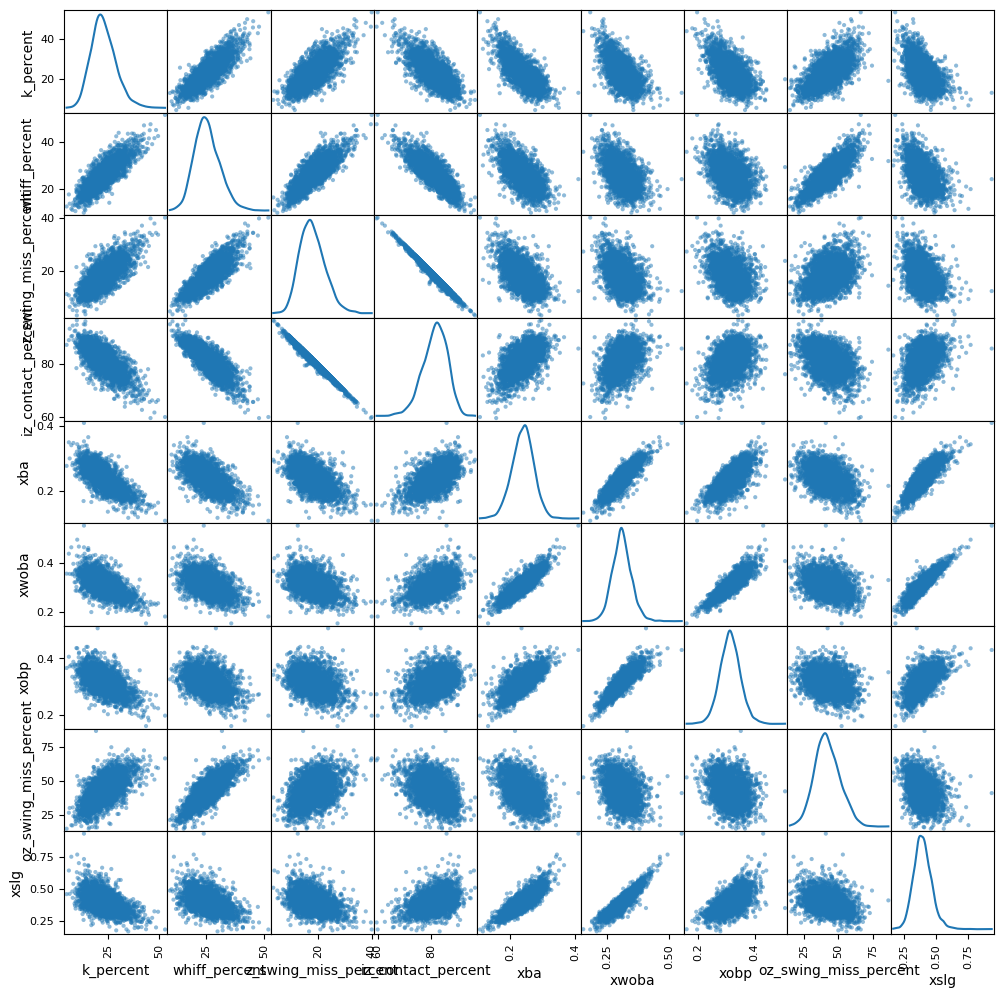

In [9]:
plot_top_x_corr(pitcher_combined, 10, "scatter", "Fpoints_IP")

Many strong correlations throughout, not as many as batting. Normally distributed. 

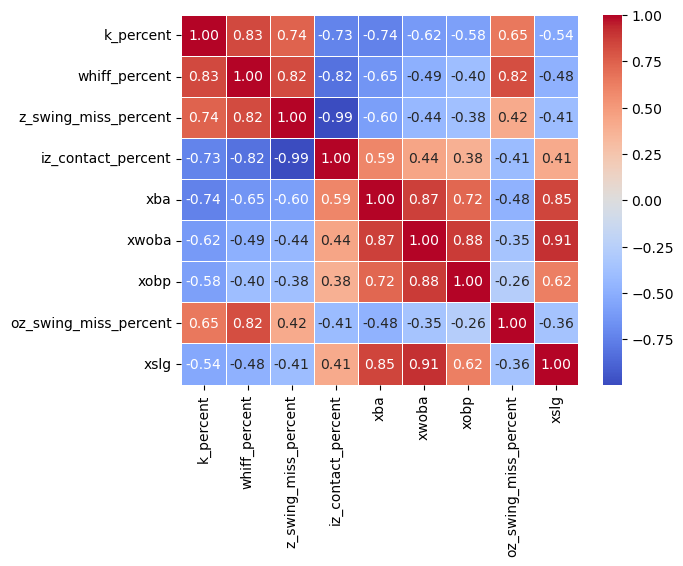

In [10]:
plot_top_x_corr(pitcher_combined, 10, "correlation", "Fpoints_IP")

In [11]:
# Adding columns that represents percentile of fpoints for the year. 
# Calculate the fantasy points from the previous year for each player
pitcher_combined['Fpoints_IP_prev_year'] = pitcher_combined.groupby('Name')['Fpoints_IP'].shift(1)

# Impute missing values in Fpoints_IP_prev_year using IterativeImputer
# Calculate the fantasy points from two previous years for each player
pitcher_combined['Fpoints_IP_two_prev_year'] = pitcher_combined.groupby('Name')['Fpoints_IP'].shift(2)

# Impute missing values in Fpoints_IP_prev_year and Fpoints_IP_two_prev_year using IterativeImputer
imputer = IterativeImputer()
pitcher_combined[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']] = imputer.fit_transform(pitcher_combined[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']])

# Calculate the weighted fantasy points for the last two years
pitcher_combined['Fpoints_IP_weighted'] = 0.7 * pitcher_combined['Fpoints_IP_prev_year'] + 0.3 * pitcher_combined['Fpoints_IP_two_prev_year']

# Calculate the percentile of the weighted fantasy points for each year
pitcher_combined['Fpoints_IP_percentile'] = pitcher_combined.groupby('year')['Fpoints_IP_weighted'].rank(pct=True)
pitcher_combined['Fpoints_IP_prev_year'] = imputer.fit_transform(pitcher_combined[['Fpoints_IP_prev_year']])

pitcher_combined['Fpoints_IP_percentile'] = pitcher_combined.groupby('year')['Fpoints_IP_prev_year'].rank(pct = True)
pitcher_combined[['Name', 'year', 'Fpoints_IP_percentile']]

,Name,year,Fpoints_IP_percentile
0,Bartolo Colon,2016,0.504651
1,Jason Grilli,2016,0.504651
2,Joaquín Benoit,2016,0.504651
3,Matt Belisle,2016,0.504651
4,CC Sabathia,2016,0.504651
...,...,...,...
3389,Ryan Pepiot,2023,0.436543
3390,Drey Jameson,2023,0.436543
3391,Louie Varland,2023,0.436543
3392,Beau Brieske,2023,0.436543


In [12]:
# K%-BB%
pitcher_combined['KpBB%'] = pitcher_combined['k_percent'] - pitcher_combined['bb_percent']

Some very strong positive and negative correlations here. Will need to be addressed in feature selection

## Train-test split

In [13]:
X = pitcher_combined.drop(columns = ['Fpoints_IP'])
y = pitcher_combined['Fpoints_IP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


na_ratio = X_train.isna().any(axis=1).mean()
print(f"Ratio of rows with NAs: {na_ratio:.2%}")

na_columns = X_train.columns[X_train.isna().any()].tolist()
print(f"Columns with NAs: {na_columns}")

X_train.head()

Ratio of rows with NAs: 12.38%
Columns with NAs: ['n_breaking_formatted', 'breaking_avg_speed', 'breaking_avg_spin', 'breaking_avg_break_x', 'breaking_avg_break_z', 'breaking_avg_break_z_induced', 'breaking_avg_break', 'breaking_range_speed', 'n_offspeed_formatted', 'offspeed_avg_speed', 'offspeed_avg_spin', 'offspeed_avg_break_x', 'offspeed_avg_break_z', 'offspeed_avg_break_z_induced', 'offspeed_avg_break']


,Name,year,age,k_percent,bb_percent,xba,xslg,woba,xwoba,xobp,...,offspeed_avg_spin,offspeed_avg_break_x,offspeed_avg_break_z,offspeed_avg_break_z_induced,offspeed_avg_break,Fpoints_IP_prev_year,Fpoints_IP_two_prev_year,Fpoints_IP_weighted,Fpoints_IP_percentile,KpBB%
2163,Danny Duffy,2021,32,23.6,9.1,0.248,0.441,0.324,0.330,0.322,...,2158.0,14.3,-27.7,11.1,18.2,1.573975,1.602151,1.582428,0.267196,14.5
2447,Geoff Hartlieb,2021,27,18.8,18.8,0.223,0.316,0.314,0.340,0.396,...,2202.0,-13.8,-26.7,8.9,16.5,1.461538,1.694391,1.531394,0.232804,0.0
2382,Taylor Widener,2021,26,25.0,13.6,0.205,0.413,0.334,0.329,0.340,...,1857.0,-16.0,-29.3,7.7,17.9,1.763108,1.784075,1.769398,0.436508,11.4
1674,Victor Alcántara,2019,26,17.6,5.0,0.244,0.393,0.290,0.294,0.280,...,1744.0,-15.8,-28.3,7.8,17.7,1.763108,1.784075,1.769398,0.478982,12.6
2019,Yonny Chirinos,2020,26,21.5,5.3,0.256,0.451,0.286,0.318,0.300,...,1294.0,-9.6,-33.6,4.1,11.0,1.948159,1.839107,1.915443,0.694915,16.2


NA values are only present in breaking balls / offspeed. Since not every pitcher throws them. Will impute these based on other characteristics

In [14]:


from sklearn.impute import SimpleImputer

# List of columns to drop
columns_to_drop = ['Name']

# Use SimpleImputer instead of IterativeImputer
first_preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('impute', SimpleImputer(strategy='mean'), na_columns),
        ('passthrough_feats', 'passthrough', X_train.columns.drop(columns_to_drop).drop(na_columns))
    ]
)

# Create a pipeline with the updated preprocessor
first_pipeline = Pipeline(steps=[('preprocessor', first_preprocessor)])


# Fit the pipeline on the training data and transform both training and test data
X_train_transformed = first_pipeline.fit_transform(X_train)
X_test_transformed = first_pipeline.transform(X_test)

transformed_features = first_preprocessor.get_feature_names_out()


first_transformed_features = [col.split('__')[-1] for col in transformed_features]
X_train_transformed = pd.DataFrame(X_train_transformed, columns=first_transformed_features, index=X_train.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=first_transformed_features, index=X_test.index)

X_train_transformed.head()


,n_breaking_formatted,breaking_avg_speed,breaking_avg_spin,breaking_avg_break_x,breaking_avg_break_z,breaking_avg_break_z_induced,breaking_avg_break,breaking_range_speed,n_offspeed_formatted,offspeed_avg_speed,...,fastball_avg_spin,fastball_avg_break_x,fastball_avg_break_z,fastball_avg_break_z_induced,fastball_avg_break,Fpoints_IP_prev_year,Fpoints_IP_two_prev_year,Fpoints_IP_weighted,Fpoints_IP_percentile,KpBB%
2163,31.3,79.4,2347.0,-6.2,-50.1,-6.6,10.0,4.0,15.3,83.9,...,2159.0,7.7,-14.8,17.2,19.3,1.573975,1.602151,1.582428,0.267196,14.5
2447,45.5,82.7,2238.0,11.9,-42.3,-2.4,12.5,1.5,0.7,87.7,...,2349.0,-15.5,-24.9,6.3,16.8,1.461538,1.694391,1.531394,0.232804,0.0
2382,20.9,85.9,2352.0,5.6,-36.3,0.9,6.2,1.5,14.0,86.3,...,2396.0,-6.9,-13.6,17.3,18.7,1.763108,1.784075,1.769398,0.436508,11.4
1674,8.9,90.0,2102.0,-4.3,-27.1,7.5,9.1,1.4,18.9,88.1,...,2066.0,-16.7,-24.4,7.6,18.5,1.763108,1.784075,1.769398,0.478982,12.6
2019,21.6,87.5,2335.0,3.6,-29.6,6.2,7.7,1.8,22.5,85.9,...,2280.0,-17.0,-20.0,11.3,20.6,1.948159,1.839107,1.915443,0.694915,16.2


## Feature Engineering

In [15]:
def calculate_yearly_averages(df, year_col='year'):
    # Group by year, then calculate the mean for each group
    yearly_averages = df.groupby(year_col).mean().reset_index()
    # Rename columns to indicate they are yearly averages
    yearly_averages.columns = [f"{col}_yearly_avg" if col != year_col else col for col in yearly_averages.columns]
    
    return yearly_averages

# Calculate yearly averages for the pitcher_combined dataframe
yearly_averages = calculate_yearly_averages(X_train_transformed)
yearly_averages.head()
# Merge the yearly averages with the training data
X_train_transformed_with_averages = X_train_transformed.merge(yearly_averages, on='year', how='left')

# Merge the yearly averages with the test data
X_test_transformed_with_averages = X_test_transformed.merge(yearly_averages, on='year', how='left')

# Drop year column as we dont need it anymore
X_train_transformed_with_averages = X_train_transformed_with_averages.drop(columns='year')
X_test_transformed_with_averages = X_test_transformed_with_averages.drop(columns='year')

X_train_transformed_with_averages.head()

,n_breaking_formatted,breaking_avg_speed,breaking_avg_spin,breaking_avg_break_x,breaking_avg_break_z,breaking_avg_break_z_induced,breaking_avg_break,breaking_range_speed,n_offspeed_formatted,offspeed_avg_speed,...,fastball_avg_spin_yearly_avg,fastball_avg_break_x_yearly_avg,fastball_avg_break_z_yearly_avg,fastball_avg_break_z_induced_yearly_avg,fastball_avg_break_yearly_avg,Fpoints_IP_prev_year_yearly_avg,Fpoints_IP_two_prev_year_yearly_avg,Fpoints_IP_weighted_yearly_avg,Fpoints_IP_percentile_yearly_avg,KpBB%_yearly_avg
0,31.3,79.4,2347.0,-6.2,-50.1,-6.6,10.0,4.0,15.3,83.9,...,2280.187702,-3.346602,-18.844984,13.097411,17.200000,1.789817,1.779739,1.786794,0.497962,15.225243
1,45.5,82.7,2238.0,11.9,-42.3,-2.4,12.5,1.5,0.7,87.7,...,2280.187702,-3.346602,-18.844984,13.097411,17.200000,1.789817,1.779739,1.786794,0.497962,15.225243
2,20.9,85.9,2352.0,5.6,-36.3,0.9,6.2,1.5,14.0,86.3,...,2280.187702,-3.346602,-18.844984,13.097411,17.200000,1.789817,1.779739,1.786794,0.497962,15.225243
3,8.9,90.0,2102.0,-4.3,-27.1,7.5,9.1,1.4,18.9,88.1,...,2238.972452,-4.101377,-19.328926,12.862810,17.007989,1.763284,1.769278,1.765082,0.505046,13.905785
4,21.6,87.5,2335.0,3.6,-29.6,6.2,7.7,1.8,22.5,85.9,...,2270.701068,-3.992883,-19.093238,13.019573,16.959075,1.738673,1.783232,1.752041,0.511124,15.244484


## Data is normally distributed (ish) so no need for square/log/root transformations. Sticking to basic operators. 

In [16]:
# import itertools
# import operator
# import numpy as np
# import warnings

# warnings.filterwarnings('ignore')

# # List of non-yearly average features
# def generate_feature_combinations(*datasets):

#     # Assuming all datasets have the same columns
#     combined_dataset = datasets[0].copy()

#     # List of non-yearly average features
#     non_yearly_avg_features = [col for col in combined_dataset.columns if 'yearly_avg' not in col]

#     # List of operations and their symbols
#     operations = ['+', '-', '*']

#     # Generate all combinations of operations for the features
#     combinations = list(itertools.combinations(non_yearly_avg_features, 2))

#     # Apply the operations to the features
#     for symbol in operations:
#         for (feature1, feature2) in combinations:
#             if feature1 != feature2:
#                 new_feature_name = f"{feature1}_{symbol}_{feature2}"
#                 if symbol == '+':
#                     for dataset in datasets:
#                         dataset[new_feature_name] = dataset[feature1] + dataset[feature2]
#                 elif symbol == '-':
#                     for dataset in datasets:
#                         dataset[new_feature_name] = dataset[feature1] - dataset[feature2]
#                 elif symbol == '*':
#                     for dataset in datasets:
#                         dataset[new_feature_name] = dataset[feature1] * dataset[feature2]

#     return datasets

# # Example usage
# X_train_transformed_with_averages, X_test_transformed_with_averages = generate_feature_combinations(X_train_transformed_with_averages, X_test_transformed_with_averages)
# X_train_transformed_with_averages.head()

In [17]:
X_test_transformed_with_averages = X_test_transformed_with_averages.reindex(columns=X_train_transformed_with_averages.columns, fill_value=0)
X_test_transformed_with_averages.head()

,n_breaking_formatted,breaking_avg_speed,breaking_avg_spin,breaking_avg_break_x,breaking_avg_break_z,breaking_avg_break_z_induced,breaking_avg_break,breaking_range_speed,n_offspeed_formatted,offspeed_avg_speed,...,fastball_avg_spin_yearly_avg,fastball_avg_break_x_yearly_avg,fastball_avg_break_z_yearly_avg,fastball_avg_break_z_induced_yearly_avg,fastball_avg_break_yearly_avg,Fpoints_IP_prev_year_yearly_avg,Fpoints_IP_two_prev_year_yearly_avg,Fpoints_IP_weighted_yearly_avg,Fpoints_IP_percentile_yearly_avg,KpBB%_yearly_avg
0,25.1,83.4,2135.0,7.3,-44.7,-4.8,9.3,1.4,1.400000,88.600000,...,2208.693252,-2.303374,-19.277914,13.383129,17.510429,1.756086,1.778568,1.762831,0.500050,13.031902
1,21.9,79.4,2927.0,8.8,-56.1,-11.2,15.1,1.6,21.200000,83.800000,...,2232.749288,-4.059829,-18.007977,14.227066,18.619943,1.746645,1.775212,1.755215,0.504949,13.868946
2,26.2,78.3,2809.0,17.0,-51.7,-6.7,18.6,2.6,13.000624,85.391514,...,2270.701068,-3.992883,-19.093238,13.019573,16.959075,1.738673,1.783232,1.752041,0.511124,15.244484
3,19.4,87.2,2422.0,1.8,-32.2,4.4,6.8,2.6,26.100000,84.500000,...,2235.412281,-3.061696,-19.048538,13.254386,17.415205,1.727548,1.773500,1.741334,0.501236,13.732749
4,51.2,75.1,2823.0,-15.7,-62.5,-12.4,20.5,2.5,1.700000,83.400000,...,2235.412281,-3.061696,-19.048538,13.254386,17.415205,1.727548,1.773500,1.741334,0.501236,13.732749


In [18]:
from sklearn.preprocessing import StandardScaler

numeric_cols = X_train_transformed_with_averages.columns.tolist()

# Update the preprocessor to scale numeric features
preprocessor = ColumnTransformer(
	transformers=[
		('scale', StandardScaler(), numeric_cols)
	]
)

# Update the pipeline with the updated preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline on the training data and transform both training and test data
X_train_preprocessed = pipeline.fit_transform(X_train_transformed_with_averages)
X_test_preprocessed = pipeline.transform(X_test_transformed_with_averages)

# Convert the preprocessed data back to a DataFrame
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train_transformed_with_averages.columns, index=X_train_transformed_with_averages.index)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=X_test_transformed_with_averages.columns, index=X_test_transformed_with_averages.index)
X_train_preprocessed.shape

(2715, 130)

In [19]:
# from sklearn.feature_selection import SelectKBest, f_regression

# # Select the top 100 features
# selector = SelectKBest(score_func=f_regression, k=100)
# X_train_reduced = selector.fit_transform(X_train_preprocessed, y_train)
# X_test_reduced = selector.transform(X_test_preprocessed)

# # Get the selected feature names
# selected_features = X_train_preprocessed.columns[selector.get_support()]

# # Convert the reduced datasets back to DataFrames
# X_train_reduced = pd.DataFrame(X_train_reduced, columns=selected_features, index=X_train_preprocessed.index)
# X_test_reduced = pd.DataFrame(X_test_reduced, columns=selected_features, index=X_test_preprocessed.index)

# X_train_reduced.head()

In [20]:
from sklearn.feature_selection import RFE, SelectKBest, f_regression, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')



    # Update classifier_params with XGBoost and LightGBM hyperparameters
def tune_and_select_model(X_train, y_train, X_test, y_test):
    # Define feature selectors
    # feature_selectors = {
    #     'pca' : PCA(),
    #     'select_k_best': SelectKBest(score_func=f_regression, k=10),
    #     'select_from_model': SelectFromModel(estimator=RandomForestRegressor())
    # }

    # Define regressors
    regressors = {
        'linear_regression': Lasso(),
        'random_forest': RandomForestRegressor(),
        'gradient_boosting': GradientBoostingRegressor(),
        'svm': SVR(),
        'neural_network': MLPRegressor()
    }

    # Define hyperparameters for feature selectors
    # feature_selector_params = {
    #     'pca__n_components': [10, 25, 50],
    #     'select_k_best__k': [10, 25, 50],
    #     'select_from_model__max_features': [10, 25, 50]
    # }

    # Define hyperparameters for regressors
    regressor_params = {
        'linear_regression__alpha': np.logspace(-4, 2, 50),
        'random_forest__n_estimators': [25, 50, 100, 200],
        'random_forest__max_depth': [2,4,6,10,14,18,25,40],
        'gradient_boosting__n_estimators': [50, 100, 200],
        'svm__C': [0.01, 0.1, 1, 10],
        'neural_network__hidden_layer_sizes': [(50,), (100,), (50, 50)]
    }

    # Create a list to store the results
    results = []

    # Iterate over feature selectors and regressors

    # Add XGBoost and LightGBM to regressors
    regressors.update({
        'xgboost': xgb.XGBRegressor(),
        'lightgbm': lgb.LGBMRegressor(verbose = -1)
    })

    # Update regressor_params with XGBoost and LightGBM hyperparameters
    regressor_params.update({
        'xgboost__n_estimators': [25,50, 100, 200],
        'xgboost__learning_rate': [0.001,0.01, 0.1, 0.2],
        'lightgbm__n_estimators': [25,50, 100, 200],
        'lightgbm__learning_rate': [0.001,0.01, 0.1, 0.2]
    })

    # for fs_name, fs in feature_selectors.items():
    for reg_name, reg in regressors.items():
        # Create a pipeline
        pipeline = Pipeline([
            # (fs_name, fs),
            (reg_name, reg)
        ])

        # Combine hyperparameters
        # params = {**{f'{k}': v for k, v in feature_selector_params.items() if k.startswith(fs_name)},
                    # **{f'{k}': v for k, v in regressor_params.items() if k.startswith(reg_name)}}

        params = {**{f'{k}': v for k, v in regressor_params.items() if k.startswith(reg_name)}}
        
        print(f' Searching {params}')

        # Perform RandomizedSearchCV
        search = RandomizedSearchCV(pipeline, param_distributions=params, n_iter=5, cv=3, random_state=42)
        print("Search complete")
        search.fit(X_train, y_train)
        print("Fit complete")

        # Get the best model
        best_model = search.best_estimator_

        # Make predictions
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        print("results calculated")

        # Store the results
        results.append({
            # 'feature_selector': fs_name,
            'regressor': reg_name,
            'best_params': search.best_params_,
            'mse': mse,
            'rmse': rmse
        })

    # Find the best result
    best_result = min(results, key=lambda x: x['rmse'])

    return best_result, results



# Example usage
# best_result, all_results = tune_and_select_model(X_train_preprocessed, y_train, X_test_preprocessed, y_test)
# print("Best Result:", best_result)
# print("All Results:", all_results)

In [21]:
# import pickle
# with open('models/pitcher_model_feb16_fangraphs.pkl', 'wb') as f:
#     pickle.dump(best_result, f)

In [22]:
## MSE with all sum/diff/multiplication features: 0.448
## MSE without: 0.446
## MSE without feature selection at all + previous percentile: 0.2
## MSE with adding fangraphs: 0.507

with open('models/pitcher_model_feb16_nofs_pct.pkl', 'rb') as f:
    loaded_best_result = pickle.load(f)

loaded_best_result

NameError: name 'pickle' is not defined

In [ ]:

# Extract the best feature selector, regressor, and parameters
# best_feature_selector_name = loaded_best_result['feature_selector']
best_regressor_name = loaded_best_result['regressor']
best_params = loaded_best_result['best_params']

# Define feature selectors
# feature_selectors = {
#     'pca': PCA(),
#     'select_k_best': SelectKBest(score_func=f_regression),
#     'select_from_model': SelectFromModel(estimator=RandomForestRegressor())
# }

# Define regressors
regressors = {
    'linear_regression': Lasso(),
    'random_forest': RandomForestRegressor(),
    'gradient_boosting': GradientBoostingRegressor(),
    'svm': SVR(),
    'neural_network': MLPRegressor(),
    'xgboost': xgb.XGBRegressor(),
    'lightgbm': lgb.LGBMRegressor()
}

# Create the pipeline with the best feature selector and regressor
best_model = Pipeline([
    # (best_feature_selector_name, feature_selectors[best_feature_selector_name]),
    (best_regressor_name, regressors[best_regressor_name])
])

# Set the best parameters
best_model.set_params(**best_params)
best_model.fit(X_train_preprocessed, y_train)




Pipeline(steps=[('linear_regression',
                 Lasso(alpha=np.float64(0.012067926406393288)))])

In [27]:
# Extract the feature importances from the best model
if hasattr(best_model.named_steps[best_regressor_name], 'feature_importances_'):
    importances = best_model.named_steps[best_regressor_name].feature_importances_
elif hasattr(best_model.named_steps[best_regressor_name], 'coef_'):
    importances = best_model.named_steps[best_regressor_name].coef_
else:
    raise ValueError(f"The model {best_regressor_name} does not have feature importances or coefficients.")

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train_preprocessed.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df.head(10)  # Display the top 10 features

,Feature,Importance
70,K-BB%,0.337949
4,breaking_avg_break_z,0.028115
1,breaking_avg_speed,0.026304
83,breaking_range_speed_yearly_avg,0.019703
27,xwobacon,0.018292
109,solidcontact_percent_yearly_avg,0.015625
51,f_strike_percent,0.014727
19,k_percent,0.013790
9,offspeed_avg_speed,0.013161
14,offspeed_avg_break,0.012029


In [28]:
import lime

import lime.lime_tabular

# Extract the gradient boosting model from the best_model pipeline
gradient_boosting_model = best_model.named_steps['linear_regression']

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_preprocessed.values,
    feature_names=X_train_preprocessed.columns,
    class_names=['Fpoints_IP'],
    mode='regression'
)

# Select an instance to explain
instance_idx = 30
instance = X_test_preprocessed.iloc[instance_idx].values.reshape(1, -1)

# Generate explanation
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=gradient_boosting_model.predict
)
# Get the name corresponding to the instance being explained
instance_name = X_test.iloc[instance_idx]['Name']
print(f"Explaining prediction for: {instance_name}")

# Show the explanation
explanation.show_in_notebook(show_table=True)

Explaining prediction for: Michael Lorenzen


In [29]:
# all_results = pd.DataFrame(all_results).sort_values(by = 'mse')
# all_results

,regressor,best_params,mse,rmse
0,linear_regression,{'linear_regression__alpha': 0.012067926406393...,0.507536,0.712415
6,lightgbm,"{'lightgbm__n_estimators': 50, 'lightgbm__lear...",0.529617,0.727748
2,gradient_boosting,{'gradient_boosting__n_estimators': 50},0.559760,0.748171
1,random_forest,"{'random_forest__n_estimators': 200, 'random_f...",0.567078,0.753046
3,svm,{'svm__C': 1},0.594582,0.771092
5,xgboost,"{'xgboost__n_estimators': 100, 'xgboost__learn...",0.618502,0.786449
4,neural_network,"{'neural_network__hidden_layer_sizes': (50,)}",0.802620,0.895891


In [30]:
## Prediciting for 2025
pitch_mets = pd.read_csv("data/pitcher_metrics.csv")
pitch_mets_2024 = pitch_mets[pitch_mets['year'] == 2024]

pitch_mets_2024["KpBB%"] = pitch_mets_2024["k_percent"] - pitch_mets_2024["bb_percent"]



pitch_mets_2024 = pitch_mets_2024.rename(columns = {"last_name, first_name":"Name"})

pitch_2024 = pitch_mets_2024.merge(fpoints2024, on = "Name")


# Impute missing values in Fpoints_IP_prev_year and Fpoints_IP_two_prev_year using IterativeImputer
pitch_2024['Fpoints_IP_prev_year'] = pitch_2024.groupby('Name')['Fpoints_IP'].shift(1)

# Impute missing values in Fpoints_IP_prev_year using IterativeImputer
# Calculate the fantasy points from two previous years for each player
pitch_2024['Fpoints_IP_two_prev_year'] = pitch_2024.groupby('Name')['Fpoints_IP'].shift(2)

# Impute missing values in Fpoints_IP_prev_year and Fpoints_IP_two_prev_year using IterativeImputer
imputer = IterativeImputer()
pitch_2024[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']] = imputer.fit_transform(pitch_2024[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']])
# Calculate the weighted fantasy points for the last two years
pitch_2024['Fpoints_IP_weighted'] = 0.7 * pitch_2024['Fpoints_IP_prev_year'] + 0.3 * pitch_2024['Fpoints_IP_two_prev_year']

# Calculate the percentile of the weighted fantasy points for each year
pitch_2024['Fpoints_IP_percentile'] = pitch_2024.groupby('year')['Fpoints_IP_weighted'].rank(pct=True)

pitch_2024.columns

Index(['Name', 'player_id', 'year', 'k_percent', 'bb_percent', 'xba', 'xslg',
       'woba', 'xwoba', 'xobp', 'xiso', 'xwobacon', 'xbacon',
       'exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent',
       'barrel_batted_rate', 'solidcontact_percent', 'flareburner_percent',
       'poorlyunder_percent', 'poorlytopped_percent', 'poorlyweak_percent',
       'hard_hit_percent', 'z_swing_miss_percent', 'oz_swing_miss_percent',
       'out_zone_percent', 'meatball_percent', 'iz_contact_percent',
       'in_zone_percent', 'edge_percent', 'whiff_percent', 'swing_percent',
       'pull_percent', 'straightaway_percent', 'opposite_percent',
       'f_strike_percent', 'groundballs_percent', 'flyballs_percent',
       'linedrives_percent', 'popups_percent', 'arm_angle',
       'n_fastball_formatted', 'fastball_avg_speed', 'fastball_avg_spin',
       'fastball_avg_break_x', 'fastball_avg_break_z',
       'fastball_avg_break_z_induced', 'fastball_avg_break',
       'n_breaking_formatted',

In [31]:
age_2024 = pd.read_csv("data/pitcher_2024_age.csv")

age_2024 = age_2024.rename(columns = {"last_name, first_name":"Name", "player_age":"age"})

pitch_mets_2024_new = pitch_2024.merge(age_2024, on = ["Name", 'year', 'player_id']).drop(columns = ['player_id'])



In [ ]:
import warnings

warnings.filterwarnings('ignore')

# Imputation processing
new_preprocessed_first = first_pipeline.transform(pitch_mets_2024_new)
new_preprocessed_first = pd.DataFrame(new_preprocessed_first, columns=first_transformed_features, index=pitch_mets_2024_new.index)

# Calculate yearly averages for the pitcher_combined dataframe
yearly_averages_new = calculate_yearly_averages(new_preprocessed_first)

# Merge the yearly averages with the training data
yearly_new_prep = new_preprocessed_first.merge(yearly_averages_new, on='year', how='left')

# Drop year column as we dont need it anymore
yearly_new_prep = yearly_new_prep.drop(columns='year')

# print(yearly_new_prep["fastball_avg_break_z_induced"])


# Generate feature combinations

# Reindex to match the training data columns

# print(yearly_new_prep)
new_transformed = pipeline.transform(yearly_new_prep)
print(new_transformed.shape)
new_transformed = pd.DataFrame(new_transformed, columns=numeric_cols, index=yearly_new_prep.index)

# expected_columns = pd.Index(selector.get_feature_names_out())  # or use the columns from the fitting data

# new_selected = new_transformed.reindex(columns=expected_columns, fill_value=0)
# new_selected = pd.DataFrame(new_selected, columns=selected_features, index=new_transformed.index)
# 
# print(new_selected.isna().sum())
# Find the columns that are different between new_transformed and X_train_preprocessed
diff_columns = set(new_transformed.columns).difference(set(X_train_preprocessed.columns))
print(f"Columns in new_transformed but not in X_train_preprocessed: {diff_columns}")

new_preds = best_model.predict(new_transformed)








ValueError: columns are missing: {'xFIP', 'Stuff+', 'K/9', 'Location+', 'SIERA', 'BB/9', 'Pitching+', 'HR/9', 'K-BB%', 'age_y', 'age_x', 'xFIP-'}

In [37]:
## Combining preds with data:
pitch_2024['proj_fpoints_ip'] = new_preds
pitch_2024[['Name', 'proj_fpoints_ip']].sort_values(by = 'proj_fpoints_ip', ascending = False).head(50)

,Name,proj_fpoints_ip
616,Mason Miller,2.702814
237,Devin Williams,2.482340
247,Griffin Jax,2.376047
464,Dedniel Núñez,2.338468
504,Garrett Crochet,2.335349
171,Edwin Díaz,2.317573
196,Josh Hader,2.283921
443,Edwin Uceta,2.275803
319,Kris Bubic,2.264219
404,Jeremiah Estrada,2.240420


In [ ]:
razz_preds = pd.read_csv("data/razzball_pitch_preds.csv")
razz_preds.head()
print(razz_preds.columns)

Index(['#', 'Name', 'Team', 'POS', 'R/L', 'G', 'GS', 'QS', 'TBF', 'IP', 'W',
       'L', 'SV', 'HLD', 'ERA', 'SIERA', 'WHIP', 'K', 'BB', 'H', 'HBP', 'ER',
       'R', 'HR', 'GB%', 'FB%', 'LD%', 'BABIP', 'RazzID'],
      dtype='object')


In [ ]:
whole_df = pitch_2024.merge(razz_preds, on = "Name", how = "left")
whole_df['proj_fpoints_skill'] = whole_df['proj_fpoints_ip'] * whole_df['IP']
whole_df['proj_fpoints'] = whole_df['proj_fpoints_skill'] + 2*whole_df['W'] - 2*whole_df['L'] + 5*whole_df['SV'] + 2*whole_df["HLD"]
final_df=whole_df[["Name", "proj_fpoints_skill", "proj_fpoints"]].sort_values(by = "proj_fpoints", ascending = False).head(50)
final_df["rank"] = final_df["proj_fpoints"].rank(ascending = False)
final_df=final_df.set_index("rank")
# final_df.to_csv("predictions/initial_picher_preds.csv")
final_df

,Name,proj_fpoints_skill,proj_fpoints
rank,,,
1.0,Tarik Skubal,368.544673,375.144673
2.0,Zack Wheeler,348.528492,359.928492
3.0,Cole Ragans,339.775272,347.175272
4.0,Blake Snell,333.457684,341.857684
5.0,Paul Skenes,334.763607,341.363607
6.0,Chris Sale,329.336376,341.336376
7.0,Logan Gilbert,329.926966,336.526966
8.0,Garrett Crochet,327.649487,332.849487
9.0,Framber Valdez,316.215090,327.015090
